## <u>Notebook Synopsis:</u> 
In the previous notebook, I developed some features for some of the models to be written and compared in the next few steps. These features include max(blue)-to-green ratio, color index, log-transformed data. The present notebook details the computation of principle components (PCs) from Rrs data for use as predictors in an additional model. While this is part of the feature engineering step of the project's workflow, it is different from the steps detailed in the previous notebook. Specifically, the features develope in the previous notebook can be extracted from out-of-sample or future data without referring to the training data used to parameterize the models. The rotation applied to extract PCs from future data is parameterized after the application of PCA to training data. Because, my intention is to set aside some of the data developed here for a classic cross-validation exercise, I have to split the data into training and validation data, run PCA on the training data and apply the matrix rotation parameterized during this step to the validation data to extract correspondent PCs. Finally I standardize the predictors and target data, where standardization is again parameterized using the training data and subsequently applied to the validation data. Note that I save both PC transformer and standardizer functions, now parameterized using the training data so that they can be part of future out-of-sample data transformation, just as applied to the validation data here. In summary, the steps detailed in this notebook are:
* Split the data into training and validation sets.
* Run PCA on training data and retain now parameterized PC extraction function.
* Standardize predictors and target data in training data, retain now parameterized standardizer function.
* Extract PC from validation data using parameterized PC extraction function.
* Standardize validation data predictors and target using parameterized standardizer function.
* Save processed training and validation data.
* Save PC extractor and standardizer function for future (i.e. out-of-sample) data pre-processing, including that of the test set. Use a scikit-learn Pipeline object to make it a single preprocessing step.

In [23]:
import pickle
from datetime import datetime as DT
import numpy as np
import pandas as pd

from yellowbrick.target import FeatureCorrelation
from yellowbrick.features import rank2d
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as pl
from matplotlib import rcParams
%matplotlib inline

In [2]:
rcParams['axes.formatter.limits'] = (-2, 3)
rcParams['axes.labelsize'] = 16
rcParams['xtick.labelsize'] = 16
rcParams['ytick.labelsize'] = 16

In [3]:
df_ = pd.read_pickle('./pickleJar/df_main_2_w_CI.pkl')

In [4]:
df_.head().T

,0,1,2,3,4
id,1565,1566,1567,1568,1559
etopo2,1e-10,1e-10,1,3,1
log_etopo2,-10,-10,0,0.477121,0
lat,38.4279,38.368,38.3074,38.6367,38.3047
rrs411,0.0012044,0.00106171,0.000971132,0.0014718,0.000905091
log_rrs411,-2.91923,-2.974,-3.01272,-2.83215,-3.04331
rrs443,0.00168608,0.00138402,0.00118548,0.00174123,0.00102233
log_rrs443,-2.77312,-2.85886,-2.9261,-2.75914,-2.99041
rrs489,0.00329309,0.00217292,0.0018432,0.00287731,0.00150593
log_rrs489,-2.4824,-2.66296,-2.73443,-2.54101,-2.8222


In [5]:
drop_cols = df_.filter(regex="(^etopo|^rrs|^chlor)",axis=1).columns

In [6]:
df = df_.drop(drop_cols, axis=1)

In [7]:
df.head().T

,0,1,2,3,4
id,1565,1566,1567,1568,1559
log_etopo2,-10,-10,0,0.477121,0
lat,38.4279,38.368,38.3074,38.6367,38.3047
log_rrs411,-2.91923,-2.974,-3.01272,-2.83215,-3.04331
log_rrs443,-2.77312,-2.85886,-2.9261,-2.75914,-2.99041
log_rrs489,-2.4824,-2.66296,-2.73443,-2.54101,-2.8222
log_rrs510,-2.39401,-2.60219,-2.6406,-2.43601,-2.72047
log_rrs555,-2.12615,-2.38173,-2.37206,-2.15604,-2.55274
log_rrs670,-2.46035,-2.77086,-2.79256,-2.49028,-2.74702
CI,0.00491563,0.00261468,0.00284955,0.00450403,0.00139934


In [8]:
df.to_feather('./pickleJar/df_log_1_w_CI.ftr')

Note on computing sd on log scale:


If Var(exp(log_rrs))≈exp$(\mu_{log\_rrs})^2\sigma^2_{log\_rrs}$

$sd(exp(log\_rrs))≈exp(\mu_{log\_rrs})\sigma_{log\_rrs}$


$\leftrightarrow \ \sigma_{log\_rrs} ≈ \frac{sd(rrs)}{exp(\mu_{log\_rrs})}$

In [9]:
df = pd.read_feather('./pickleJar/df_log_1_w_CI.ftr')

In [10]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,4459.0,4377.381251,2298.272102,6.000000,2028.500000,5039.000000,6271.500000,7831.000000
log_etopo2,4459.0,1.820020,2.692464,-10.000000,1.255273,2.380211,3.445526,3.901894
lat,4459.0,1.868658,44.765125,-77.035600,-61.299000,27.093000,34.458500,79.690000
log_rrs411,4293.0,-2.419273,0.326394,-4.290672,-2.600448,-2.399659,-2.200602,-1.514280
log_rrs443,4456.0,-2.421040,0.292499,-3.721171,-2.582159,-2.409061,-2.216361,-1.434521
log_rrs489,4422.0,-2.395443,0.224659,-3.546531,-2.515600,-2.381635,-2.247581,-1.195083
log_rrs510,3435.0,-2.447466,0.220647,-3.583095,-2.548050,-2.465355,-2.372431,-1.109354
log_rrs555,3255.0,-2.611693,0.292241,-3.737064,-2.799234,-2.683803,-2.502876,-1.331613
log_rrs670,1598.0,-3.501395,1.625059,-10.000000,-3.699328,-3.212071,-2.698897,-1.557521
CI,1163.0,0.002061,0.003488,-0.006578,0.000274,0.001315,0.003598,0.023865


The next steps include:
* drop nans across rows for a consistent data sets for all models to be developed
* split training/testing sets
    * with stratification around the MaxBlueBandIdx
    * relaxed CI assumption that only hplc data is to be used.
* PCA for log_rrs data
    * PCA transformer parameterized using training data
    * Same parameterization applied to testing data
* Standardize all continous data
    * As for PCA, parameterize standardizer using training data
    * apply same parameterization to testing data
* The last 2 steps above could be built into a scikit-learn pipeline and saved (including parameterizations mentioned above) for ease of retrieval when needed for future pre-processing of out-of-sample data.

### Train/Test Sets Splitting

I do two splits, one with rows containing >=1 nan dropped, and one with nans kept. The latter is to retain the option of bayesian data modeling-based imputation.

In [11]:
train_idx_no_nans, test_idx_no_nans = train_test_split(df.dropna().index.values, 
                                                       test_size=0.2,
                                                       random_state=47,
                                                       shuffle=True,
                                                       stratify=df.dropna().MaxBlueBandIdx)

In [12]:
df.dropna().loc[train_idx_no_nans].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 841 entries, 737 to 1475
Data columns (total 18 columns):
id                841 non-null int64
log_etopo2        841 non-null float64
lat               841 non-null float64
log_rrs411        841 non-null float64
log_rrs443        841 non-null float64
log_rrs489        841 non-null float64
log_rrs510        841 non-null float64
log_rrs555        841 non-null float64
log_rrs670        841 non-null float64
CI                841 non-null float64
CI_OK             841 non-null int64
MaxBlue           841 non-null float64
MaxBlueBand       841 non-null object
MaxBlueBandIdx    841 non-null int8
mxBlue2Gr         841 non-null float64
log_mxBlue2Gr     841 non-null float64
log_chlor_a       841 non-null float64
is_hplc           841 non-null bool
dtypes: bool(1), float64(13), int64(2), int8(1), object(1)
memory usage: 113.3+ KB


In [13]:
df.dropna().loc[test_idx_no_nans].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 211 entries, 1182 to 3960
Data columns (total 18 columns):
id                211 non-null int64
log_etopo2        211 non-null float64
lat               211 non-null float64
log_rrs411        211 non-null float64
log_rrs443        211 non-null float64
log_rrs489        211 non-null float64
log_rrs510        211 non-null float64
log_rrs555        211 non-null float64
log_rrs670        211 non-null float64
CI                211 non-null float64
CI_OK             211 non-null int64
MaxBlue           211 non-null float64
MaxBlueBand       211 non-null object
MaxBlueBandIdx    211 non-null int8
mxBlue2Gr         211 non-null float64
log_mxBlue2Gr     211 non-null float64
log_chlor_a       211 non-null float64
is_hplc           211 non-null bool
dtypes: bool(1), float64(13), int64(2), int8(1), object(1)
memory usage: 28.4+ KB


In [14]:
train_idx, test_idx = train_test_split(df.index.values, test_size=0.2, 
                                       random_state=47,
                                       shuffle=True, 
                                       stratify=df.MaxBlueBandIdx.values)

In [15]:
df.loc[train_idx].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3567 entries, 3273 to 3673
Data columns (total 18 columns):
id                3567 non-null int64
log_etopo2        3567 non-null float64
lat               3567 non-null float64
log_rrs411        3434 non-null float64
log_rrs443        3564 non-null float64
log_rrs489        3536 non-null float64
log_rrs510        2734 non-null float64
log_rrs555        2590 non-null float64
log_rrs670        1271 non-null float64
CI                917 non-null float64
CI_OK             3567 non-null int64
MaxBlue           3567 non-null float64
MaxBlueBand       3567 non-null object
MaxBlueBandIdx    3567 non-null int8
mxBlue2Gr         2590 non-null float64
log_mxBlue2Gr     2590 non-null float64
log_chlor_a       3303 non-null float64
is_hplc           3567 non-null bool
dtypes: bool(1), float64(13), int64(2), int8(1), object(1)
memory usage: 480.7+ KB


In [16]:
df.loc[test_idx].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 892 entries, 3350 to 165
Data columns (total 18 columns):
id                892 non-null int64
log_etopo2        892 non-null float64
lat               892 non-null float64
log_rrs411        859 non-null float64
log_rrs443        892 non-null float64
log_rrs489        886 non-null float64
log_rrs510        701 non-null float64
log_rrs555        665 non-null float64
log_rrs670        327 non-null float64
CI                246 non-null float64
CI_OK             892 non-null int64
MaxBlue           892 non-null float64
MaxBlueBand       892 non-null object
MaxBlueBandIdx    892 non-null int8
mxBlue2Gr         665 non-null float64
log_mxBlue2Gr     665 non-null float64
log_chlor_a       824 non-null float64
is_hplc           892 non-null bool
dtypes: bool(1), float64(13), int64(2), int8(1), object(1)
memory usage: 120.2+ KB


In [17]:
with open('./pickleJar/train_test_indices', 'wb') as fb:
    tt_pkl_d = dict(train_idx=train_idx, test_idx=test_idx,
                    train_idx_no_nans=train_idx_no_nans,
                    test_idx_no_nans=test_idx_no_nans)
    pickle.dump(tt_pkl_d, fb, protocol=pickle.HIGHEST_PROTOCOL)

In [18]:
with open('./pickleJar/train_test_indices' ,'rb') as fb:
    tt_pkl_d = pickle.load(fb)
    train_idx = tt_pkl_d['train_idx']
    test_idx = tt_pkl_d['test_idx']
    train_idx_no_nans = tt_pkl_d['train_idx_no_nans']
    test_idx_no_nans = tt_pkl_d['test_idx_no_nans']
    del tt_pkl_d

### Standardization and PCA Steps


1. Standardize all continuous data other than log_rrs
2. Apply PCA to log_rrs
    1. All inputs are centered automatically; retain all PCs
    2. standardize PCs

Note that I wrap the PCA part in a scikit-learn pipeline

In [19]:
df.drop(['MaxBlue', 'mxBlue2Gr'], axis=1, inplace=True)

Below are the two column-wise split datasets to which different transformations will be applied

In [20]:
df.filter(regex='rrs', axis=1).head()

,log_rrs411,log_rrs443,log_rrs489,log_rrs510,log_rrs555,log_rrs670
0,-2.919229,-2.773122,-2.482397,-2.394012,-2.126145,-2.460352
1,-2.973995,-2.858857,-2.662956,-2.602191,-2.381734,-2.770862
2,-3.012722,-2.926105,-2.734427,-2.640597,-2.372060,-2.792560
3,-2.832150,-2.759143,-2.541014,-2.436014,-2.156039,-2.490282
4,-3.043308,-2.990409,-2.822196,-2.720468,-2.552735,-2.747020


In [21]:
df.select_dtypes(include=['float64']).filter(regex='^(?!log_rrs)', axis=1).head()

,log_etopo2,lat,CI,log_mxBlue2Gr,log_chlor_a
0,-10.000000,38.4279,0.004916,-0.267867,1.581950
1,-10.000000,38.3680,0.002615,-0.220457,1.544192
2,0.000000,38.3074,0.002850,-0.268537,1.429914
3,0.477121,38.6367,0.004504,-0.279976,1.680879
4,0.000000,38.3047,0.001399,-0.167733,1.371991


In [24]:
pca_pipeline = Pipeline(steps=[('std1', StandardScaler()),
                               ('pca', PCA()), 
                               ('std2', StandardScaler())])

In [25]:
std_columns = df.select_dtypes(include=['float64']
                              ).filter(regex='^(?!log_rrs)', 
                                       axis=1).columns
pca_columns = df.filter(regex='rrs', axis=1).columns

In [26]:
other_columns = df.select_dtypes(exclude=['float64']).columns

In [27]:
train_4_pca = df.dropna().loc[train_idx_no_nans, pca_columns].values
train_other_float = df.dropna().loc[train_idx_no_nans, std_columns].values
train_other = df.dropna().loc[train_idx_no_nans, other_columns].values

In [28]:
test_4_pca = df.dropna().loc[test_idx_no_nans, pca_columns].values
test_other_float = df.dropna().loc[test_idx_no_nans, std_columns].values
test_other = df.dropna().loc[test_idx_no_nans, other_columns]

#### Initialize and parameterize standardizer for continuous data other than log_rrs
This includes transforming the relevant training data

In [29]:
std_other_float = StandardScaler()
train_other_float_s = std_other_float.fit_transform(train_other_float)

#### Initialize and parameterize pca pipeline
... includes transforming relevant training data

In [30]:
train_pca_s = pca_pipeline.fit_transform(train_4_pca)

#### Repackaged transformed training data into dataframe

In [31]:
df_train_s = pd.concat((pd.DataFrame(train_other, columns=other_columns, 
                                    index=train_idx_no_nans),
                        pd.DataFrame(train_pca_s, 
                                     columns=[f'PC_{i+1}_s'
                                              for i in range(len(pca_columns))], 
                                     index=train_idx_no_nans),
                        pd.DataFrame(train_other_float_s, 
                                     columns=[f'{col}_s' for col in std_columns],
                                     index=train_idx_no_nans)),axis=1)

In [32]:
df_train_s.head().T

,737,1150,1408,1401,3833
id,2884,2848,2092,2085,7735
CI_OK,0,0,0,0,0
MaxBlueBand,Rrs510,Rrs510,Rrs443,Rrs443,Rrs510
MaxBlueBandIdx,2,2,0,0,2
is_hplc,True,True,False,False,True
PC_1_s,0.250868,-1.08876,0.119565,0.408611,2.02415
PC_2_s,-0.432209,-0.544728,3.49006,3.38701,-0.330321
PC_3_s,-0.564519,0.13296,3.75965,3.83071,0.353855
PC_4_s,-1.58842,-2.03883,-0.678995,-0.589311,1.14744
PC_5_s,0.447675,0.198388,0.0760644,-0.153215,1.50644


In [33]:
df_train_s.describe().T

,count,mean,std,min,25%,50%,75%,max
PC_1_s,841.0,-2.112196e-18,1.000595,-3.048077,-0.496888,0.006525,0.549386,4.173965
PC_2_s,841.0,-7.392686e-18,1.000595,-2.025163,-0.716200,-0.201185,0.488161,3.661889
PC_3_s,841.0,2.112196e-17,1.000595,-1.911771,-0.535901,-0.064246,0.447128,5.232586
PC_4_s,841.0,-1.056098e-17,1.000595,-3.546035,-0.633123,0.036597,0.651964,4.360081
PC_5_s,841.0,-4.224392e-18,1.000595,-3.594243,-0.522532,0.003441,0.509902,5.428894
PC_6_s,841.0,-2.534635e-17,1.000595,-3.878286,-0.622469,0.005082,0.663350,4.277352
log_etopo2_s,841.0,-5.491710e-17,1.000595,-3.937734,-0.053743,0.140070,0.416346,0.962690
lat_s,841.0,1.013854e-16,1.000595,-4.967524,-0.050091,0.115666,0.591559,0.935178
CI_s,841.0,-8.448784e-18,1.000595,-2.434711,-0.588852,-0.202449,0.470230,6.136048
log_mxBlue2Gr_s,841.0,3.590733e-17,1.000595,-1.630917,-0.733669,-0.341401,0.577047,2.832714


#### Stash the transformers, preserving their current parameterization, for potential re-use on out-of-sample data.

In [34]:
with open(f'./pickleJar/transformers_dict_{DT.now()}.pkl', 'wb') as fb:
    transformers_dict = dict(other_float_standardizer=std_other_float,
                             pca_pipeline=pca_pipeline)
    pickle.dump(transformers_dict, fb, protocol=pickle.HIGHEST_PROTOCOL)

#### Transform testing data using parameterized transformers

In [35]:
test_other_float_s = std_other_float.transform(test_other_float)
test_pca_s = pca_pipeline.transform(test_4_pca)

In [36]:
df_test_s = pd.concat((pd.DataFrame(test_other, columns=other_columns, 
                                    index=test_idx_no_nans),
                        pd.DataFrame(test_pca_s, 
                                     columns=[f'PC_{i+1}_s'
                                              for i in range(len(pca_columns))], 
                                     index=test_idx_no_nans),
                        pd.DataFrame(test_other_float_s, 
                                     columns=[f'{col}_s' for col in std_columns],
                                     index=test_idx_no_nans)),axis=1)

#### Quick eval of PCs:

In [37]:
# Plotting explained variance of principle components
explained_var_ratio = pca_pipeline.named_steps['pca'].explained_variance_ratio_

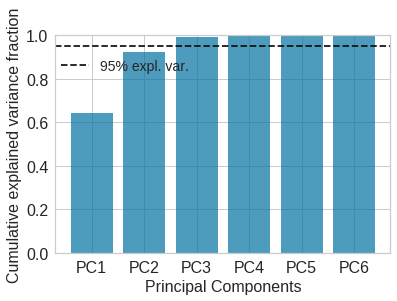

In [38]:
_, ax = pl.subplots(figsize=(6, 4))
ax.bar([f'PC{i}' for i in range(1, 7)],
       np.cumsum(explained_var_ratio), alpha=0.7);
ax.set_ylabel('Cumulative explained variance fraction')
ax.set_xlabel('Principal Components');
ax.set_ylim(0, 1)
ax.axhline(0.95, color='k', ls='--', label='95% expl. var.')
ax.legend(loc=(0, 0.8), fontsize=14);

The graph above doesn't seem to support the inclusion of more than the first couple of PCs.

#### Save both dataframes

In [39]:
df_train_s.reset_index(inplace=True)
df_test_s.reset_index(inplace=True)
df_train_s.to_feather(f'./pickleJar/df_train_s_{DT.now()}.feather')
df_test_s.to_feather(f'./pickleJar/df_test_s_{DT.now()}.feather')

---
This is the end of this notebook